<a href="https://colab.research.google.com/github/julianencisoizquierdo/NLP_Exploring_Vectorization/blob/main/NLP_Exploration_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Loading Packages and importing data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging
import string
import regex as re

import spacy
import nltk

from tqdm.auto import tqdm

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
import json

# Initialize an empty list to store the loaded data
reviews = []

file_path = "/content/drive/MyDrive/reviews_5_balanced.json"

#loading each JSON object individually
with open(file_path, 'r') as json_file:
    for line in json_file:
        row = json.loads(line)
        reviews.append(row)

reviews = pd.DataFrame(reviews)

In [ ]:
reviews.head()

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime
0,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800
1,1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800
2,1,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR5G,"Was terribly disappointed, the pants were way too large in the legs, my husband looked like he was wearing blown up clown pants.","Was terribly disappointed, the pants were way too large in ...",1486512000
3,1,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR4W,"Was terribly disappointed, the pants were way too large in the legs, my husband looked like he was wearing blown up clown pants.","Was terribly disappointed, the pants were way too large in ...",1486512000
4,1,True,"02 19, 2018",A276HQXYS553QW,B0014F8TIU,Constantly rolls down,One Star,1518998400


In [ ]:
reviews.shape

(294240, 8)

In [ ]:
reviews.duplicated().sum()

0

<Axes: >

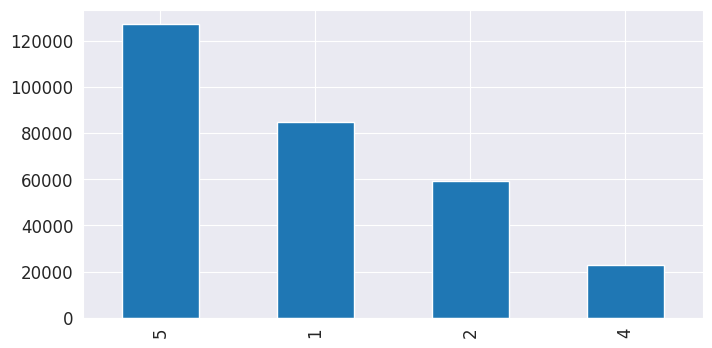

In [ ]:
reviews["overall"].value_counts().plot(kind = 'bar')

In [ ]:
#Create a new column "sentiment" based on the values in the "overall" column
reviews['sentiment'] = reviews['overall'].apply(lambda rating: 1 if rating >= 4 else 0)
reviews.drop(columns=['overall'], inplace=True)

reviews['sentiment'].value_counts()


1    150000
0    144240
Name: sentiment, dtype: int64

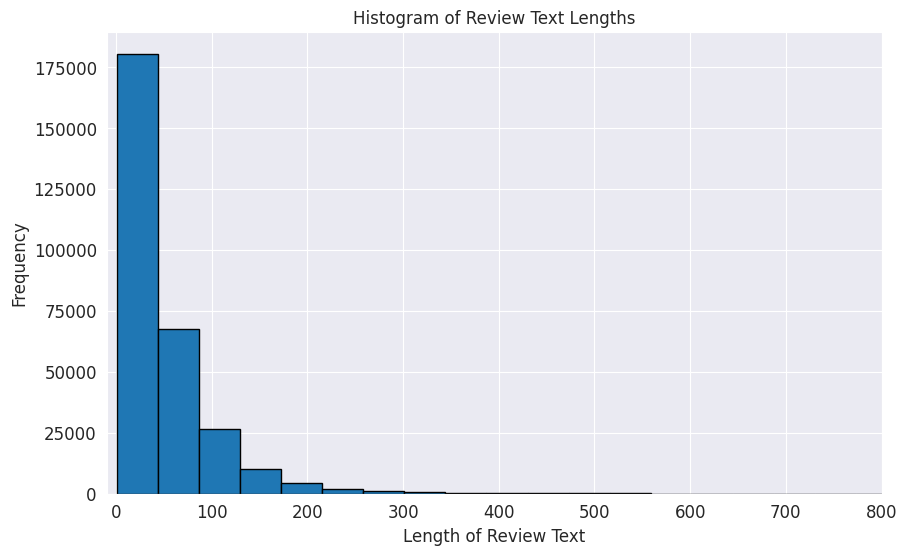

In [ ]:
#Review lengths
review_lengths = [len(review) for review in reviews['reviewText']]
plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, edgecolor='black')
plt.title('Histogram of Review Text Lengths')
plt.xlabel('Length of Review Text')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(-10,800)
plt.show()

#**Data Splitting**

In [ ]:
X = reviews.drop(columns = "sentiment")
y = reviews["sentiment"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**Preprocessing non-text columns**

In [ ]:
#Feature engineering: creating length column
X_train["length"] = X_train["reviewText"].apply(len)

In [ ]:
#Date-Time parsing
import datetime

X_train['reviewDatetime'] = pd.to_datetime(X_train['unixReviewTime'], unit='s')
X_train[['unixReviewTime', 'reviewDatetime', 'reviewTime']].head()

,unixReviewTime,reviewDatetime,reviewTime
59800,1478476800,2016-11-07,"11 7, 2016"
33693,1495756800,2017-05-26,"05 26, 2017"
222324,1386633600,2013-12-10,"12 10, 2013"
83482,1450051200,2015-12-14,"12 14, 2015"
233907,1452643200,2016-01-13,"01 13, 2016"


In [ ]:
#Extracting date components
X_train['year'] = X_train['reviewDatetime'].dt.year
X_train['month'] = X_train['reviewDatetime'].dt.month
X_train['day'] = X_train['reviewDatetime'].dt.day

X_train.drop(columns=['reviewDatetime','reviewTime',"unixReviewTime"], inplace=True)

In [ ]:
#Binary encoding "Verified"
X_train['verified'] = X_train['verified'].map({True: 1, False: 0})

In [ ]:
#Feature selection (dropping irrelevant columns)
X_train.drop(columns=['reviewerID','asin','summary'], inplace=True)

In [ ]:
reviews.head()

,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,sentiment
0,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR5G,Waaaay too BIG,One Star,1520812800,0
1,True,"03 12, 2018",A3QY3THQ42WSCQ,B000YFSR4W,Waaaay too BIG,One Star,1520812800,0
2,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR5G,"Was terribly disappointed, the pants were way too large in the legs, my husband looked like he was wearing blown up clown pants.","Was terribly disappointed, the pants were way too large in ...",1486512000,0
3,True,"02 8, 2017",A21HH0VIBKK80J,B000YFSR4W,"Was terribly disappointed, the pants were way too large in the legs, my husband looked like he was wearing blown up clown pants.","Was terribly disappointed, the pants were way too large in ...",1486512000,0
4,True,"02 19, 2018",A276HQXYS553QW,B0014F8TIU,Constantly rolls down,One Star,1518998400,0


#**Text Preprocessing**

In [ ]:
#Punctuation
def remove_punctuation(text):
    for punctuation_char in string.punctuation:
        text = text.replace(punctuation_char, '')
    return text

In [ ]:
#Normalizing repeated letters (example: turning "waaay" into "way")
def normalize_repeated_letters(text):
    pattern = r'(\w)\1{2,}'
    # Use re.sub() to replace the matched patterns with a single occurrence of the letter
    normalized_text = re.sub(pattern, r'\1', text)
    return normalized_text

#testing function
text1 = "biiig"
print(normalize_repeated_letters(text1))


big


In [ ]:
#Stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords = set(remove_punctuation(word) for word in stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
include_stopwords = {'must', 'would', 'also', 'could'}
exclude_stopwords = {'against', 'below'}
stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [ ]:
#Preprocessing Pipeline:

pipeline = [str.lower, remove_punctuation, normalize_repeated_letters]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [ ]:
X_train['reviewText'] = X_train['reviewText'].apply(prepare, pipeline=pipeline)

#**Replicate Preprocessing steps on Test Data**

In [ ]:
# Creating length column
X_test["length"] = X_test["reviewText"].apply(len)

# Parsing date-time
X_test['reviewDatetime'] = pd.to_datetime(X_test['unixReviewTime'], unit='s')

# Extracting date components
X_test['year'] = X_test['reviewDatetime'].dt.year
X_test['month'] = X_test['reviewDatetime'].dt.month
X_test['day'] = X_test['reviewDatetime'].dt.day

# Binary encoding "Verified"
X_test['verified'] = X_test['verified'].map({True: 1, False: 0})

# Feature selection (dropping irrelevant columns)
X_test.drop(columns=['reviewerID', 'asin', 'summary', 'reviewTime', 'unixReviewTime', 'reviewDatetime'], inplace=True)

# ReviewText Preprocessing
X_test['reviewText'] = X_test['reviewText'].apply(prepare, pipeline=pipeline)


#**Vectorization**

#*Word Embeddings: with FastText*

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199772 sha256=4fdfd1dd6ad442dae7f64428490116cbfca516fc877e3686c23b2846a5183b36
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import copy
X_train_ft = copy.deepcopy(X_train)
X_test_ft = copy.deepcopy(X_test)

In [ ]:
X_train_ft.head()

,verified,reviewText,length,year,month,day
59800,1,good,4,2016,11,7
33693,1,didnt work for my mode cheap,35,2017,5,26
222324,1,great price and good quality parts,35,2013,12,10
83482,1,broke,5,2015,12,14
233907,1,great price very happy,23,2016,1,13


In [ ]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenization
tokenized_reviews = X_train_ft['reviewText'].apply(word_tokenize)

In [ ]:
# Training FastText model
model = FastText(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4, sg=1)


In [ ]:
# Vectorization
def get_review_vector(review_tokens):
    review_vectors = [model.wv[token] for token in review_tokens if token in model.wv]
    if len(review_vectors) > 0:
        return sum(review_vectors) / len(review_vectors)
    else:
        return [0] * model.vector_size  # Return a zero vector if none of the tokens are in vocabulary

In [ ]:
X_train_ft['review_vectors'] = tokenized_reviews.apply(get_review_vector)

In [ ]:
X_test_ft['review_vectors'] = X_test_ft['reviewText'].apply(word_tokenize).apply(get_review_vector)

In [ ]:
X_train_ft.head()

,verified,reviewText,length,year,month,day,review_vectors
59800,1,good,4,2016,11,7,"[-0.28997514, 0.048838723, -0.19265603, -0.1256631, -0.19848472, -0.061940547, 0.94486564, 0.6463618, -0.23717202, -0.05442978, -0.17467603, -0.12763709, -0.38960543, 0.8418443, -0.17050187, -0.36..."
33693,1,didnt work for my mode cheap,35,2017,5,26,"[-0.12206348, 0.0009939075, -0.27901793, -0.21486242, 0.03402398, -0.10715225, 0.33686224, 0.6613545, 0.08777704, -0.12660937, 0.091057666, 0.05896334, -0.1486553, 0.58042854, -0.22071002, -0.3366..."
222324,1,great price and good quality parts,35,2013,12,10,"[-0.15740258, 0.11798432, -0.41478074, -0.11610851, -0.010546893, -0.17459084, 0.48342022, 0.68497294, -0.33376184, -0.1104502, -0.010936583, -0.1942653, -0.281934, 0.6624226, -0.5067416, -0.34165..."
83482,1,broke,5,2015,12,14,"[0.30481142, 0.5621369, -0.079778545, -0.6028547, -0.5394007, -0.2656759, -0.091605656, 1.2312977, 0.5459899, -0.57884085, 0.6180737, -0.0060732407, -0.71587485, 0.19128288, -0.86484885, -0.294429..."
233907,1,great price very happy,23,2016,1,13,"[-0.07515233, 0.026704386, -0.30204543, -0.32192266, 0.004156925, -0.22827333, 0.47223562, 0.74206847, -0.3167853, 0.053787097, -0.22099847, -0.12916046, -0.41580987, 0.67049944, -0.49020383, -0.3..."


In [ ]:
# Vector aggregation function
def aggregate_vectors(vectors):
    if len(vectors) == 0:
        return np.zeros_like(vectors[0])
    else:
        return np.mean(vectors, axis=0)

In [ ]:
X_train_ft['review_vectors'] = X_train_ft['review_vectors'].apply(aggregate_vectors)
X_test_ft['review_vectors'] = X_test_ft['review_vectors'].apply(aggregate_vectors)

In [ ]:
X_train_ft.drop(columns = 'reviewText', inplace = True)
X_test_ft.drop(columns = 'reviewText', inplace = True)

> **Classification model**: Ridge Regression



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_classification_model(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()
ridge_model.fit(X_train_ft, y_train)

Ridge()

In [ ]:
# Model performance on test set
y_pred = ridge_model.predict(X_test_ft)
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)
evaluate_classification_model(y_test, y_pred)

Accuracy: 0.6990551930396954
Precision: 0.713458805587328
Recall: 0.6855163686015919
F1 Score: 0.699208532898536
Confusion Matrix:
[[20554  8267]
 [ 9443 20584]]




> **Classification Model:** Random Forest




In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_ft, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model performance on test set
test_pred_ft = rf_classifier.predict(X_test_ft)
evaluate_classification_model(y_test, test_pred_ft)

Accuracy: 0.7185800706905927
Precision: 0.7292475314947225
Recall: 0.7132913710993439
F1 Score: 0.7211812044379347
Confusion Matrix:
[[20869  7952]
 [ 8609 21418]]


#*Topic Modeling: LDA*

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
count_vectorizer = CountVectorizer(stop_words = list(stopwords), min_df=0.001, max_df=0.95)

In [ ]:
X_train.head()

,verified,reviewText,length,year,month,day
59800,1,good,4,2016,11,7
33693,1,didnt work for my mode cheap,35,2017,5,26
222324,1,great price and good quality parts,35,2013,12,10
83482,1,broke,5,2015,12,14
233907,1,great price very happy,23,2016,1,13


In [ ]:
count_vectors = count_vectorizer.fit_transform(X_train['reviewText'])

In [ ]:
lda_model = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=-1)

In [ ]:
# Document_topic matrix
doc_topic = lda_model.fit_transform(count_vectors)

In [ ]:
# Topic-term matrix
topic_term = lda_model.components_

In [ ]:
print(doc_topic.shape, topic_term.shape)

(235392, 10) (10, 758)


In [ ]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [ ]:
display_topics(lda_model, count_vectorizer.get_feature_names_out())


Topic 00
  work (18.26)
  love (14.11)
  really (7.32)
  taste (6.63)
  like (3.57)

Topic 01
  phone (7.97)
  well (7.95)
  case (6.59)
  like (5.20)
  easy (3.41)

Topic 02
  use (6.01)
  one (5.42)
  much (5.19)
  expected (4.54)
  used (3.37)

Topic 03
  cheap (6.44)
  money (6.20)
  bad (4.98)
  waste (3.39)
  never (3.15)

Topic 04
  fit (12.57)
  small (4.70)
  even (3.71)
  returned (2.51)
  recommend (2.50)

Topic 05
  way (2.84)
  like (2.50)
  get (2.15)
  cant (2.04)
  color (1.97)

Topic 06
  great (34.45)
  perfect (8.35)
  product (6.70)
  price (6.58)
  ok (5.41)

Topic 07
  product (12.92)
  buy (5.86)
  made (3.56)
  item (3.51)
  described (3.29)

Topic 08
  broke (3.87)
  one (3.16)
  get (2.98)
  excellent (2.96)
  months (2.79)

Topic 09
  good (35.40)
  works (15.75)
  nice (8.93)
  great (7.94)
  quality (7.88)


> **Classification Model**: Ridge Regression



In [ ]:
X_train_lda = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(doc_topic)], axis=1)
X_test_lda = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(lda_model.transform(count_vectorizer.transform(X_test['reviewText'])))], axis=1)

In [ ]:
topic_columns = [f"Topic_{i}" for i in range(doc_topic.shape[1])]
X_train_lda.columns = list(X_train.columns) + topic_columns
X_test_lda.columns = list(X_test.columns) + topic_columns

In [ ]:
X_train_lda.head()

,verified,reviewText,length,year,month,day,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,1,good,4,2016,11,7,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55
1,1,didnt work for my mode cheap,35,2017,5,26,0.37,0.03,0.03,0.37,0.03,0.03,0.03,0.03,0.03,0.03
2,1,great price and good quality parts,35,2013,12,10,0.02,0.02,0.02,0.02,0.17,0.02,0.02,0.02,0.02,0.70
3,1,broke,5,2015,12,14,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05
4,1,great price very happy,23,2016,1,13,0.03,0.03,0.03,0.03,0.03,0.03,0.52,0.27,0.03,0.03


In [ ]:
X_train_lda.drop(columns = 'reviewText', inplace = True)
X_test_lda.drop(columns = 'reviewText', inplace = True)

In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train_lda, y_train)

# Predict on the test set
y_pred_lda = ridge_model.predict(X_test_lda)


In [ ]:
threshold = 0.5
y_pred_lda = (y_pred_lda >= threshold).astype(int)

In [ ]:
evaluate_classification_model(y_test, y_pred_lda)

Accuracy: 0.7159631593257205
Precision: 0.772853980487005
Recall: 0.6278682519066173
F1 Score: 0.6928575366127047
Confusion Matrix:
[[23280  5541]
 [11174 18853]]



> **Classification Model:** Random Forest



In [ ]:
rf_classifier.fit(X_train_lda, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model performance on test set
y_pred_rf = rf_classifier.predict(X_test_lda)
evaluate_classification_model(y_test, y_pred_rf)

Accuracy: 0.800350054377379
Precision: 0.8312912346842601
Recall: 0.7637126586072535
F1 Score: 0.7960703313488274
Confusion Matrix:
[[24167  4654]
 [ 7095 22932]]


LDA 25 topics

In [ ]:
lda_model_25 = LatentDirichletAllocation(n_components=25, random_state=42, n_jobs=-1)

In [ ]:
# Document_topic matrix
doc_topic_25 = lda_model_25.fit_transform(count_vectors)

# Topic-term matrix
topic_term_25 = lda_model_25.components_

In [ ]:
display_topics(lda_model_25, count_vectorizer.get_feature_names_out())


Topic 00
  work (34.78)
  really (14.04)
  long (6.63)
  junk (5.92)
  hard (5.84)

Topic 01
  phone (20.88)
  case (17.26)
  easy (11.84)
  install (5.31)
  charge (3.85)

Topic 02
  much (13.72)
  expected (11.94)
  better (11.86)
  light (5.95)
  water (5.19)

Topic 03
  cheap (12.48)
  money (12.20)
  waste (6.58)
  return (5.12)
  broken (4.81)

Topic 04
  fit (31.11)
  small (8.46)
  even (5.31)
  recommend (4.52)
  pretty (4.03)

Topic 05
  way (10.26)
  car (6.78)
  color (5.99)
  big (5.87)
  easily (5.10)

Topic 06
  great (68.95)
  perfect (17.46)
  worked (3.61)
  item (1.42)
  value (1.42)

Topic 07
  product (31.96)
  buy (18.80)
  worked (10.59)
  quickly (3.16)
  grow (2.99)

Topic 08
  still (5.64)
  months (5.15)
  working (4.85)
  two (4.43)
  days (3.18)

Topic 09
  screen (12.06)
  cover (6.56)
  purchase (4.74)
  piece (4.15)
  protector (4.15)

Topic 10
  good (57.89)
  product (6.92)
  fast (5.77)
  price (5.65)
  quality (5.03)

Topic 11
  get (19.70)
  fits (



> **Classification:** Ridge Regression







In [ ]:
X_train_lda25 = pd.concat([X_train.reset_index(drop=True), pd.DataFrame(doc_topic_25)], axis=1)
X_test_lda25 = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(lda_model_25.transform(count_vectorizer.transform(X_test['reviewText'])))], axis=1)

In [ ]:
topic_columns = [f"Topic_{i}" for i in range(doc_topic_25.shape[1])]
X_train_lda25.columns = list(X_train.columns) + topic_columns
X_test_lda25.columns = list(X_test.columns) + topic_columns

In [ ]:
X_train_lda25.drop(columns = 'reviewText', inplace = True)
X_test_lda25.drop(columns = 'reviewText', inplace = True)

In [ ]:
from sklearn.linear_model import Ridge
ridge_model = Ridge()
ridge_model.fit(X_train_lda25, y_train)

Ridge()

In [ ]:
# Predict on the test set
y_pred_lda25 = ridge_model.predict(X_test_lda25)

In [ ]:
threshold = 0.5
y_pred_lda25 = (y_pred_lda25 >= threshold).astype(int)

In [ ]:
evaluate_classification_model(y_test, y_pred_lda25)

Accuracy: 0.7346044045676998
Precision: 0.7663302650548963
Recall: 0.6903786592067139
F1 Score: 0.7263744349837065
Confusion Matrix:
[[22500  6321]
 [ 9297 20730]]



> **Classification:** Random Forest




In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
rf_classifier.fit(X_train_lda25, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Model performance on test set
ypred_lda25 = rf_classifier.predict(X_test_lda25)
evaluate_classification_model(y_test, ypred_lda25)


Accuracy: 0.7801624524197933
Precision: 0.8119979553088944
Recall: 0.7406334299130782
F1 Score: 0.7746756074196639
Confusion Matrix:
[[23672  5149]
 [ 7788 22239]]


#*TF_IDF Vectorization (No Lemmatization)*

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words = list(stopwords), min_df=.001, max_df = .95) #exclude terms that appear in less than 0,1% or more than 95% of documents

In [ ]:
X_train

,verified,reviewText,length,year,month,day
59800,1,good,4,2016,11,7
33693,1,didnt work for my mode cheap,35,2017,5,26
222324,1,great price and good quality parts,35,2013,12,10
83482,1,broke,5,2015,12,14
233907,1,great price very happy,23,2016,1,13
...,...,...,...,...,...,...
119879,1,didnt work,11,2018,3,31
259178,1,works like the orginal,23,2015,8,1
131932,1,china,5,2017,3,13
146867,1,best face wash for cystic acne,31,2016,10,18


In [ ]:
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"])

In [ ]:
tfidf_vectors.shape

(235392, 758)

In [ ]:
print("Vocabulary size:", len(tfidf_vectorizer.vocabulary_))
print("Sample vocabulary:", list(tfidf_vectorizer.vocabulary_.items())[:10])

Vocabulary size: 758
Sample vocabulary: [('good', 272), ('work', 741), ('cheap', 109), ('great', 274), ('price', 495), ('quality', 518), ('parts', 464), ('broke', 75), ('happy', 287), ('simple', 589)]


In [ ]:
from scipy.sparse import hstack
X_train_sparse = hstack([X_train.drop(columns = 'reviewText').values, tfidf_vectors])
X_train_sparse.shape

(235392, 763)



---


**TF_IDF on X_test** (using  TF-IDF vectorizer instance fit on the training set)







In [ ]:
tfidf_test = tfidf_vectorizer.transform(X_test['reviewText'])

In [ ]:
X_test_sparse = hstack([X_test.drop(columns = 'reviewText').values, tfidf_test])



> **Classification Model**: Ridge Regression


In [ ]:
print(X_train_sparse.shape, y_train.shape, X_test_sparse.shape, y_test.shape)

(235392, 763) (235392,) (58848, 763) (58848,)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_classification_model(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:")
    print(cm)


In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train_sparse, y_train)

Ridge()

In [ ]:
# Model performance on test set
test_predictions = ridge_model.predict(X_test_sparse)
threshold = 0.5
test_predictions = (test_predictions >= threshold).astype(int)
evaluate_classification_model(y_test, test_predictions)

Accuracy: 0.849952419793366
Precision: 0.8746244388674843
Recall: 0.8240583474872615
F1 Score: 0.8485887719057581
Confusion Matrix:
[[25274  3547]
 [ 5283 24744]]


> **Classification model 2:** Random Forest



In [ ]:

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_sparse, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Model performance on test set
test_predictions_rf = rf_classifier.predict(X_test_sparse)
evaluate_classification_model(y_test, test_predictions_rf)

Accuracy: 0.8627141109298532
Precision: 0.8767250257466529
Recall: 0.8505345189329603
F1 Score: 0.8634312084791318
Confusion Matrix:
[[25230  3591]
 [ 4488 25539]]


#*TF_IDF Vectorization (Lemmatization)*

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Lemmatization

In [ ]:
import spacy

In [ ]:
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text data with lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct])

In [ ]:
X_train_lem = copy.deepcopy(X_train)
X_test_lem = copy.deepcopy(X_test)

In [ ]:
# Apply lemmatization to your text data (this might take some time depending on your dataset size)
X_train_lem['reviewText'] = X_train_lem['reviewText'].apply(lemmatize_text)
X_test_lem['reviewText'] = X_test_lem['reviewText'].apply(lemmatize_text)

TFIDF vectorization

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=0.001, max_df=0.95)
tfidf_vectors = tfidf_vectorizer.fit_transform(X_train_lem['reviewText'])

In [ ]:
X_train_sparse_lem = hstack([X_train_lem.drop(columns='reviewText').values, tfidf_vectors])

# TF-IDF on X_test (using the TF-IDF vectorizer instance fit on the training set)
tfidf_test = tfidf_vectorizer.transform(X_test_lem['reviewText'])
X_test_sparse_lem = hstack([X_test_lem.drop(columns='reviewText').values, tfidf_test])

In [ ]:
print("Vocabulary size post lemmatization:", len(tfidf_vectorizer.vocabulary_))
print("Sample vocabulary:", list(tfidf_vectorizer.vocabulary_.items())[:10])

> **Classification Model**: Ridge Regression

In [ ]:
ridge_model = Ridge()
ridge_model.fit(X_train_sparse_lem, y_train)

Ridge()

In [ ]:
# Model performance on test set
test_predictions_lem = ridge_model.predict(X_test_sparse_lem)
threshold = 0.5
test_predictions_lem = (test_predictions_lem >= threshold).astype(int)
evaluate_classification_model(y_test, test_predictions_lem)

Accuracy: 0.8400285481239804
Precision: 0.8656213416580936
Recall: 0.8126352949012555
F1 Score: 0.8382918785213688
Confusion Matrix:
[[25033  3788]
 [ 5626 24401]]


> **Classification Model**: Random Forest

In [ ]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_sparse_lem, y_train)
test_predictions_rf_lem = rf_classifier.predict(X_test_sparse_lem)
evaluate_classification_model(y_test, test_predictions_rf_lem)

Accuracy: 0.8595194399129962
Precision: 0.8745008949469916
Recall: 0.846105172011856
F1 Score: 0.8600687215423417
Confusion Matrix:
[[25175  3646]
 [ 4621 25406]]
